# Deep Learning Applications: Laboratory #1

In this first laboratory we will work relatively simple architectures to get a feel for working with Deep Models. This notebook is designed to work with PyTorch, but as I said in the introductory lecture: please feel free to use and experiment with whatever tools you like.



## Exercise 1: Warming Up
In this series of exercises I want you to try to duplicate (on a small scale) the results of the ResNet paper:

> [Deep Residual Learning for Image Recognition](https://arxiv.org/abs/1512.03385), Kaiming He, Xiangyu Zhang, Shaoqing Ren, Jian Sun, CVPR 2016.

We will do this in steps using a Multilayer Perceptron on MNIST.

Recall that the main message of the ResNet paper is that **deeper** networks do not **guarantee** more reduction in training loss (or in validation accuracy). Below you will incrementally build a sequence of experiments to verify this for an MLP. A few guidelines:

+ I have provided some **starter** code at the beginning. **NONE** of this code should survive in your solutions. Not only is it **very** badly written, it is also written in my functional style that also obfuscates what it's doing (in part to **discourage** your reuse!). It's just to get you *started*.
+ These exercises ask you to compare **multiple** training runs, so it is **really** important that you factor this into your **pipeline**. Using [Tensorboard](https://pytorch.org/tutorials/recipes/recipes/tensorboard_with_pytorch.html) is a **very** good idea -- or, even better [Weights and Biases](https://wandb.ai/site).
+ You may work and submit your solutions in **groups of at most two**. Share your ideas with everyone, but the solutions you submit *must be your own*.

First some boilerplate to get you started, then on to the actual exercises!

### Imports and Weights and Biases login

Main imports to run the code.
Installation, login and eventually update of wandb.

In [1]:
# Start with some standard imports.
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
import torch
from torchvision.datasets import MNIST
from torchvision.datasets import CIFAR10
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms

from torch.optim.lr_scheduler import MultiStepLR

#Tracking experiments with wandb
%pip install -q wandb
import wandb
wandb.login()

Note: you may need to restart the kernel to use updated packages.


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: niccolo-arati (dla-labs). Use `wandb login --relogin` to force relogin


True

### Exercise 1.1: A baseline MLP

Implement a *simple* Multilayer Perceptron to classify the 10 digits of MNIST (e.g. two *narrow* layers). Use my code above as inspiration, but implement your own training pipeline -- you will need it later. Train this model to convergence, monitoring (at least) the loss and accuracy on the training and validation sets for every epoch. Below I include a basic implementation to get you started -- remember that you should write your *own* pipeline!

**Note**: This would be a good time to think about *abstracting* your model definition, and training and evaluation pipelines in order to make it easier to compare performance of different models.

**Important**: Given the *many* runs you will need to do, and the need to *compare* performance between them, this would **also** be a great point to study how **Tensorboard** or **Weights and Biases** can be used for performance monitoring.

### MNIST Dataset

In [ ]:
# Standard MNIST transform.
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))])

# Load MNIST train and test.
dataset_train = MNIST(root='./data', train=True, download=True, transform=transform) # 60000 images
ds_test = MNIST(root='./data', train=False, download=True, transform=transform) # 10000 images

classes = ('0', '1', '2', '3', '4', '5', '6', '7', '8', '9')

# Split train set into train and validation sets.
val_size = 5000
#set seed to always have the same training/validation sets
np.random.seed(111)
I = np.random.permutation(len(dataset_train)) # Order MNIST_train randomly.
ds_val = Subset(dataset_train, I[:val_size])  # Sample a validation set.
ds_train = Subset(dataset_train, I[val_size:])

### Parametrized MLP
Implementation of a parametrized Multilayer Perceptron. 
The required parameters are the size of the input and the output associated with the current MLP (set by default with the dimensions of MNIST images, 28x28, and MNIST number of classes, 10) and an array called layers, which specifies the size of the hidden layers (see the example below).

In [2]:
class MultiLayerPerceptron(nn.Module):
    def __init__(self, input_size = 784, output_size = 10, layers = [32, 32]):
        super().__init__()

        self.first_layer = nn.Linear(input_size, layers[0])
        self.inner_layers = nn.ModuleList([nn.Linear(layers[i], layers[i + 1]) for i in range(len(layers) - 1)])
        self.last_layer = nn.Linear(layers[-1], output_size)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.first_layer(x))
        for layer in self.inner_layers:
            x = F.relu(layer(x))
        x = F.relu(self.last_layer(x))
        return x

In [3]:
# Example model
model = MultiLayerPerceptron(layers = [32, 32, 32])
model

MultiLayerPerceptron(
  (first_layer): Linear(in_features=784, out_features=32, bias=True)
  (inner_layers): ModuleList(
    (0-1): 2 x Linear(in_features=32, out_features=32, bias=True)
  )
  (last_layer): Linear(in_features=32, out_features=10, bias=True)
)

### Training, evaluation and testing
The following code defines training, evaluation and test loops which will be used by every model defined in this notebook. A single function has been defined for both evaluation and testing, since most of the code would have been identical. A boolean parameter called test is used to distinguish the final part of the code associated with the function evaluate (during evaluation we compute the validation accuracy, while during testing we compute the confusion matrix).

In [2]:
# Import for better visualization of a running epoch
from tqdm import tqdm

# Trainig loop for a single epoch over the dataloader
def train(model, optimizer, dl_train, epoch, device = 'cuda'):
    model.train()
    # Save losses of this epoch
    train_losses = []

    for (x_train, y_train) in tqdm(dl_train, desc=f'Training epoch {epoch}', leave=True):
        x_train, y_train = x_train.to(device), y_train.to(device)
        # Training step for current batch
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss = F.cross_entropy(y_pred, y_train)

        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())

    return (np.mean(train_losses))


# Imports to implement the visualization of a Confusion Matrix associated with testing
import pandas as pd
import seaborn as sn
from sklearn.metrics import confusion_matrix

# Evaluation and Testing
def evaluate(model, dl_val, val_size, classes, device = 'cuda', test = False):
    model.eval()
    val_corr = 0
    val_losses = []
    y_val_conf = [] # Ground truths
    predicted_conf = []

    # Disable gradient computation and reduce memory consumption.
    with torch.no_grad():
        for data_val in dl_val:
            x_val, y_val = data_val
            y_val_conf.extend(y_val.detach().cpu().numpy()) # Collect ground truths
            x_val, y_val = x_val.to(device), y_val.to(device)

            y_pred = model(x_val)
            loss_val = F.cross_entropy(y_pred, y_val)
            val_losses.append(loss_val.item())

            predicted = torch.max(y_pred.data, 1)[1]
            predicted_conf.extend(predicted.detach().cpu().numpy())
            val_corr += (predicted == y_val).sum().item()

    val_accuracy = val_corr / val_size
    if not test:
        print(f'Validation accuracy: {val_accuracy * 100}%')

    else:
        # Build confusion matrix
        cf_matrix = confusion_matrix(y_val_conf, predicted_conf)
        df_cm = pd.DataFrame(cf_matrix / np.sum(cf_matrix, axis=1)[:, None], index = [i for i in classes],
                            columns = [i for i in classes])
        plt.figure(figsize = (12,7))
        sn.heatmap(df_cm, annot=True)
        # Plt.savefig('output.png')

    return np.mean(val_losses), val_accuracy

### Training MLP
The following code is used to train MLPs with MNIST dataset and different depths (number of layers), in order to evaluate the impact of this parameter for the accuracy of the final model predictions. The expected results are that as the depth increases, the accuracy will fall.

I tried to set the depths to find the threshold beyond which performance would start to decline (in terms of classification accuracy).

In [ ]:
# Track run, depth = 2
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab1-Submission",
    # Pass a run name
    name=f"MLP depth 2",
    # Track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "MLP",
    "dataset": "mnist",
    "epochs": 100,
    "batch_size": 128,
    "validation_set_size": 5000,
    "layers": [64]})

# Dataloaders
dl_train = torch.utils.data.DataLoader(ds_train, run.config["batch_size"], shuffle=True)
dl_val   = torch.utils.data.DataLoader(ds_val, run.config["batch_size"])
dl_test  = torch.utils.data.DataLoader(ds_test, run.config["batch_size"], shuffle=True)

# Training and Validation
device = 'cuda'

modelMLP = MultiLayerPerceptron(layers = run.config["layers"]).to(device)
optimizer = torch.optim.Adam(modelMLP.parameters(), lr=run.config["learning_rate"])

torch.manual_seed(111)
best_accuracy = 0
state_dict = None
for epoch in range(run.config["epochs"]):
    train_loss = train(modelMLP, optimizer, dl_train, epoch)
    metrics = {"Train Loss": train_loss}

    validation_loss, validation_accuracy = evaluate(modelMLP, dl_val, run.config["validation_set_size"], classes)
    # Early stopping
    if validation_accuracy >= best_accuracy:
        state_dict = modelMLP.state_dict()
        best_accuracy = validation_accuracy
    val_metrics = {"Validation Loss": validation_loss,
                   "Validation Accuracy": validation_accuracy}

    wandb.log({**metrics, **val_metrics})

# Test
modelMLP.load_state_dict(state_dict) # Take model with best validation accuracy

_, test_accuracy = evaluate(modelMLP, dl_test, 10000, classes, test=True)

print(f'Accuracy report on TEST: {test_accuracy*100}%')
test_metrics = {"Test Accuracy": test_accuracy}
wandb.log({**test_metrics})

wandb.finish()

![Alt text](cm1.png)

In [ ]:
# Track run, depth = 5
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab1-Submission",
    # Pass a run name
    name=f"MLP depth 5",
    # Track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "MLP",
    "dataset": "mnist",
    "epochs": 100,
    "batch_size": 128,
    "validation_set_size": 5000,
    "layers": [64, 64, 64, 64]})

# Dataloaders
dl_train = torch.utils.data.DataLoader(ds_train, run.config["batch_size"], shuffle=True)
dl_val   = torch.utils.data.DataLoader(ds_val, run.config["batch_size"])
dl_test  = torch.utils.data.DataLoader(ds_test, run.config["batch_size"], shuffle=True)

# Training and Validation
device = 'cuda'

modelMLP = MultiLayerPerceptron(layers = run.config["layers"]).to(device)
optimizer = torch.optim.Adam(modelMLP.parameters(), lr=run.config["learning_rate"])

torch.manual_seed(111)
best_accuracy = 0
state_dict = None
for epoch in range(run.config["epochs"]):
    train_loss = train(modelMLP, optimizer, dl_train, epoch)
    metrics = {"Train Loss": train_loss}

    (validation_loss, validation_accuracy) = evaluate(modelMLP, dl_val, run.config["validation_set_size"], classes)
    # Early stopping
    if validation_accuracy >= best_accuracy:
        state_dict = modelMLP.state_dict()
        best_accuracy = validation_accuracy
    val_metrics = {"Validation Loss": validation_loss,
                   "Validation Accuracy": validation_accuracy}

    wandb.log({**metrics, **val_metrics})

# Test
modelMLP.load_state_dict(state_dict) # Take model with best validation accuracy

_, test_accuracy = evaluate(modelMLP, dl_test, 10000, classes, test=True)

print(f'Accuracy report on TEST: {test_accuracy*100}%')
test_metrics = {"Test Accuracy": test_accuracy}
wandb.log({**test_metrics})

wandb.finish()

![Alt text](cm2.png)

In [ ]:
# Track run, depth = 7
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab1-Submission",
    # Pass a run name
    name=f"MLP depth 7",
    # Track hyperparameters and run metadata
    config={
    "learning_rate": 0.0001,
    "architecture": "MLP",
    "dataset": "mnist",
    "epochs": 100,
    "batch_size": 128,
    "validation_set_size": 5000,
    "layers": [64, 64, 64, 64, 64, 64]})

# Dataloaders
dl_train = torch.utils.data.DataLoader(ds_train, run.config["batch_size"], shuffle=True)
dl_val   = torch.utils.data.DataLoader(ds_val, run.config["batch_size"])
dl_test  = torch.utils.data.DataLoader(ds_test, run.config["batch_size"], shuffle=True)

# Training
device = 'cuda'

modelMLP = MultiLayerPerceptron(layers = run.config["layers"]).to(device)
optimizer = torch.optim.Adam(modelMLP.parameters(), lr=run.config["learning_rate"])

torch.manual_seed(111)
best_accuracy = 0
state_dict = None
for epoch in range(run.config["epochs"]):
    train_loss = train(modelMLP, optimizer, dl_train, epoch)
    metrics = {"Train Loss": train_loss}

    (validation_loss, validation_accuracy) = evaluate(modelMLP, dl_val, run.config["validation_set_size"], classes)
    # Early stopping
    if validation_accuracy >= best_accuracy:
        state_dict = modelMLP.state_dict()
        best_accuracy = validation_accuracy
    val_metrics = {"Validation Loss": validation_loss,
                   "Validation Accuracy": validation_accuracy}

    wandb.log({**metrics, **val_metrics})

# Test
modelMLP.load_state_dict(state_dict) # Take model with best validation accuracy

(_, test_accuracy) = evaluate(modelMLP, dl_test, 10000, classes, test=True)

print(f'Accuracy report on TEST: {test_accuracy*100}%')
test_metrics = {"Test Accuracy": test_accuracy}
wandb.log({**test_metrics})

wandb.finish()

![Alt text](cm3.png)

### wandb MLP Report

https://wandb.ai/dla-labs/Lab1-Submission/reports/MLP-Report--Vmlldzo5MTI3NzI4

Runs are executed with same hyperparameters and only the depth changes, so even if they could still be further optimized it is fine for comparison between the 3 different runs.
From the report, we can see that the run with depth 2 is much more stable compared to the other two. Simply increasing the depth by 3 and 5 already shows the first negative effects on image classification. Specifically, looking at the second confusion matrix, we can observe that the first digits to be misclassified are 4 and 6, both confused with 0, while in the third one 7 and 9 are misclassified with 0.
For this first simple experiments our expectations are therefore confirmed.

### Exercise 1.2: Rinse and Repeat

Repeat the verification you did above, but with **Convolutional** Neural Networks. If you were careful about abstracting your model and training code, this should be a simple exercise. Show that **deeper** CNNs *without* residual connections do not always work better and **even deeper** ones *with* residual connections.

**Hint**: You probably should do this exercise using CIFAR10, since MNIST is *very* easy (at least up to about 99% accuracy).

**Spoiler**: If you plan to do optional exercise 2.3, you should think *very* carefully about the architectures of your CNNs here (so you can reuse them!).

### Cifar10 Dataset

In [4]:
# Load CIFAR-10
train_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.RandomHorizontalFlip(p=0.5),
     transforms.RandomAffine(degrees = 10, scale = (0.8, 1.2)),
     transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2),
     transforms.RandomCrop(28),
     transforms.Resize((32, 32)),
     transforms.Normalize([0.4914, 0.4822, 0.4465], [0.2470, 0.2435, 0.2616])])

test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])

trainset = CIFAR10(root='./data', train=True, download=True, transform=train_transform)
ds_test = CIFAR10(root='./data', train=False, download=True, transform=test_transform)

# Split train set into train and validation sets.
val_size = 5000
# Set seed
np.random.seed(111)
I = np.random.permutation(len(trainset))
ds_val = Subset(trainset, I[:val_size])
ds_train = Subset(trainset, I[val_size:])

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


### Parametrized CNN
Implementation of a parametrized CNN. The required parameters are an array to specify the number of blocks contained in each of the 3 layers specified in this architecture (in the original architecture 4 layers were presented, I decided to remove one in order to compress the images less), the number of classes (10 for the dataset Cifar10) and a boolean parameter which enables the presence of residual connections inside blocks.

Compared to the original CNN architecture, I also avoided to use batch normalization, since it helps with convergence and gradient stability and this could interfere with the goal of this notebook.

In [5]:
class BasicBlock(nn.Module):
    def __init__(self, inplanes, planes, size = 3, stride = 1, downsample = None, padding = 1, residual=False):
        super().__init__()
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=size, stride=stride, padding=padding, bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=size, padding=padding, bias=False)
        self.residual = residual
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        identity = x.clone()

        x = self.relu(self.conv1(x))

        x = self.conv2(x)

        if self.residual:
            if self.downsample is not None:
                identity = self.downsample(identity)
            x += identity # Residual connection
        x = self.relu(x)

        return x

# Layers: number of blocks for each layer
class CNN(nn.Module):
    def __init__(self, layers=[1, 1, 1], num_classes=10, residual=False):
        super().__init__()

        self.residual = residual
        self.inplanes = 64
        self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3, bias=False) # Input channels = 3
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1, ceil_mode=True)

        self.layer1 = self.make_layer(64, layers[0])
        self.layer2 = self.make_layer(128, layers[1], stride=2)
        self.layer3 = self.make_layer(256, layers[2], stride=2)
        #self.layer4 = self.make_layer(512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(256, num_classes)
        
        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                m.weight.data.normal_(0, 0.01)

    def make_layer(self, planes, blocks, stride = 1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            downsample = nn.Conv2d(self.inplanes, planes, kernel_size = 1, stride = stride, bias = False)

        layers = []
        layers.append(BasicBlock(self.inplanes, planes, stride=stride, downsample=downsample, residual=self.residual))
        self.inplanes = planes
        for _ in range(blocks - 1):
            layers.append(BasicBlock(self.inplanes, planes, residual=self.residual))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        #x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

### Training CNNs without residual connection
The following code implements the training of CNNs with Cifar10 dataset and no residual connections, increasing the number of layers in order to evaluate the impact of the depth parameter for the accuracy of the final model predictions. The expected results are that as the depth increases, the accuracy of the classification predictions will fall.

In [ ]:
# Track run, depth = 8
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab1-Submission",
    # Pass a run name
    name=f"CNN depth 8",
    # Track hyperparameters and run metadata
    config={
    "initial_learning_rate": 0.001,
    "architecture": "CNN",
    "dataset": "Cifar10",
    "epochs": 100,
    "batch_size": 256,
    "validation_set_size": 5000,
    "layers": [1, 1, 1]})

# Dataloaders
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=run.config["batch_size"], shuffle=True)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size=run.config["batch_size"])
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=run.config["batch_size"], shuffle=False)

# Training and Validation
device = 'cuda'

modelCNN = CNN(layers=run.config["layers"]).to(device)
optimizer = torch.optim.Adam(params=modelCNN.parameters(), lr=run.config["initial_learning_rate"])
scheduler = MultiStepLR(optimizer, milestones=[80, 160], gamma=0.1) # Learning rate scheduler

torch.manual_seed(111)
best_accuracy = 0
state_dict = None
for epoch in range(run.config["epochs"]):
    train_loss = train(modelCNN, optimizer, dl_train, epoch)
    metrics = {"Train Loss": train_loss}

    validation_loss, validation_accuracy = evaluate(modelCNN, dl_val, run.config["validation_set_size"], classes)
    # Early stopping
    if validation_accuracy >= best_accuracy:
        state_dict = modelCNN.state_dict()
        best_accuracy = validation_accuracy
    val_metrics = {"Validation Loss": validation_loss,
                   "Validation Accuracy": validation_accuracy}

    scheduler.step()

    wandb.log({**metrics, **val_metrics})

# Test
modelCNN.load_state_dict(state_dict) # Take model with best validation accuracy

# Save model on weights and biases (will be eventually used in exercise 2.3)
model_artifact = wandb.Artifact(
    "CNN_8", type="model",
    description="best model for CNN with depth 8",
    metadata=dict(run.config))

torch.save(modelCNN.state_dict(), "best_model_cnn8.pth")
model_artifact.add_file("best_model_cnn8.pth")
wandb.save("best_model_cnn8.pth")
run.log_artifact(model_artifact)

_, test_accuracy = evaluate(modelCNN, dl_test, 10000, classes, test=True)

print(f'Accuracy report on TEST: {test_accuracy*100}%')
test_metrics = {"Test Accuracy": test_accuracy}
wandb.log({**test_metrics})

wandb.finish()

![Alt text](cm4.png)

In [ ]:
# Track run, depth = 14
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab1-Submission",
    # Pass a run name
    name=f"CNN depth 14",
    # Track hyperparameters and run metadata
    config={
    "initial_learning_rate": 0.001,
    "architecture": "CNN",
    "dataset": "Cifar10",
    "epochs": 100,
    "batch_size": 256,
    "validation_set_size": 5000,
    "layers": [2, 2, 2]})

# Dataloaders
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=run.config["batch_size"], shuffle=True)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size=run.config["batch_size"])
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=run.config["batch_size"], shuffle=False)

# Training and Validation
device = 'cuda'

modelCNN = CNN(layers=run.config["layers"]).to(device)
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=run.config["initial_learning_rate"])
scheduler = MultiStepLR(optimizer, milestones=[80, 160], gamma=0.1)

torch.manual_seed(111)
best_accuracy = 0
state_dict = None
for epoch in range(run.config["epochs"]):
    train_loss = train(modelCNN, optimizer, dl_train, epoch)
    metrics = {"Train Loss": train_loss}

    validation_loss, validation_accuracy = evaluate(modelCNN, dl_val, run.config["validation_set_size"], classes)
    # Early stopping
    if validation_accuracy >= best_accuracy:
        state_dict = modelCNN.state_dict()
        best_accuracy = validation_accuracy
    val_metrics = {"Validation Loss": validation_loss,
                   "Validation Accuracy": validation_accuracy}

    scheduler.step()

    wandb.log({**metrics, **val_metrics})

# Test
modelCNN.load_state_dict(state_dict) # Take model with best validation accuracy

# Save model on weights and biases (will be eventually used in exercise 2.3)
model_artifact = wandb.Artifact(
    "CNN_14", type="model",
    description="best model for CNN with depth 14",
    metadata=dict(run.config))

torch.save(modelCNN.state_dict(), "best_model_cnn14.pth")
model_artifact.add_file("best_model_cnn14.pth")
wandb.save("best_model_cnn.pth")
run.log_artifact(model_artifact)

_, test_accuracy = evaluate(modelCNN, dl_test, 10000, classes, test=True)

print(f'Accuracy report on TEST: {test_accuracy*100}%')
test_metrics = {"Test Accuracy": test_accuracy}
wandb.log({**test_metrics})

wandb.finish()

![Alt text](cm5.png)

In [ ]:
# Track run, depth = 16
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab1-Submission",
    # Pass a run name
    name=f"CNN depth 16",
    # Track hyperparameters and run metadata
    config={
    "initial_learning_rate": 0.001,
    "architecture": "CNN",
    "dataset": "Cifar10",
    "epochs": 100,
    "batch_size": 256,
    "validation_set_size": 5000,
    "layers": [3, 2, 2]})

# Dataloaders
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=run.config["batch_size"], shuffle=True)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size=run.config["batch_size"])
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=run.config["batch_size"], shuffle=False)

# Training and Validation
device = 'cuda'

modelCNN = CNN(layers=run.config["layers"]).to(device)
optimizer = torch.optim.Adam(modelCNN.parameters(), lr=run.config["initial_learning_rate"])
scheduler = MultiStepLR(optimizer, milestones=[80, 160], gamma=0.1)

torch.manual_seed(111)
best_accuracy = 0
state_dict = None
for epoch in range(run.config["epochs"]):
    train_loss = train(modelCNN, optimizer, dl_train, epoch)
    metrics = {"Train Loss": train_loss}

    validation_loss, validation_accuracy = evaluate(modelCNN, dl_val, run.config["validation_set_size"], classes)
    # Early stopping
    if validation_accuracy >= best_accuracy:
        state_dict = modelCNN.state_dict()
        best_accuracy = validation_accuracy
    val_metrics = {"Validation Loss": validation_loss,
                   "Validation Accuracy": validation_accuracy}

    scheduler.step()

    wandb.log({**metrics, **val_metrics})

# Test
modelCNN.load_state_dict(state_dict) # Take model with best validation accuracy

# Save model on weights and biases (will be eventually used in exercise 2.3)
model_artifact = wandb.Artifact(
    "CNN_16", type="model",
    description="best model for CNN with depth 16",
    metadata=dict(run.config))

torch.save(modelCNN.state_dict(), "best_model_cnn16.pth")
model_artifact.add_file("best_model_cnn16.pth")
wandb.save("best_model_cnn16.pth")
run.log_artifact(model_artifact)

_, test_accuracy = evaluate(modelCNN, dl_test, 10000, classes, test=True)

print(f'Accuracy report on TEST: {test_accuracy*100}%')
test_metrics = {"Test Accuracy": test_accuracy}
wandb.log({**test_metrics})

wandb.finish()

![Alt text](cm6.png)

### wandb CNN without residual connections Report

https://wandb.ai/dla-labs/Lab1-Submission/reports/CNN-Report--Vmlldzo5MTI4MDIy

From the report, we observe that the training with depth 8 and 14 is more unstable compared to those with smaller-depth MLP architectures. This is likely due to the change in the dataset.

However, in this experiment we observe as well that increasing the depth leads to a decrease in classification accuracy. This is particularly evident when comparing the runs with depth 8 and 14, since the decline seems gradually between these two runs.

 When the depth is set to 16 there is a sharp drop in performance, with the model ending up classifying every image with the same label. This is probably caused by the vanishing gradient problem, which seems to happen in the very first few epochs since the performance remains stable during all the training epochs. Maybe this could be solved by implementing batch normalization.

### Training CNNs with residual connections
The following code contains the training of CNNs with residual connection on Cifar10 dataset, varying the number of layers of the architecture, in order to evaluate the impact of the depth parameter for the accuracy of the final model predictions. The expected results are that by using residual connections, the depth will not affect anymore the accuracy.

In [ ]:
# Track run, depth = 8
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab1-Submission",
    # Pass a run name
    name=f"ResidualCNN depth 8",
    # Track hyperparameters and run metadata
    config={
    "initial_learning_rate": 0.001,
    "architecture": "ResidualCNN",
    "dataset": "Cifar10",
    "epochs": 100,
    "batch_size": 256,
    "validation_set_size": 5000,
    "layers": [1, 1, 1]})

# Dataloaders
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=run.config["batch_size"], shuffle=True)
dl_val   = torch.utils.data.DataLoader(ds_val, batch_size=run.config["batch_size"])
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=run.config["batch_size"], shuffle=False)

# Training and Validation
device = 'cuda'

modelCNNR = CNN(layers=run.config["layers"], residual=True).to(device)
optimizer = torch.optim.Adam(modelCNNR.parameters(), lr=run.config["initial_learning_rate"])
scheduler = MultiStepLR(optimizer, milestones=[80, 160], gamma=0.1)

torch.manual_seed(111)
best_accuracy = 0
state_dict = None
for epoch in range(run.config["epochs"]):
    train_loss = train(modelCNNR, optimizer, dl_train, epoch)
    metrics = {"Train Loss": train_loss}

    validation_loss, validation_accuracy = evaluate(modelCNNR, dl_val, run.config["validation_set_size"], classes)
    # Early stopping
    if validation_accuracy >= best_accuracy:
        state_dict = modelCNNR.state_dict()
        best_accuracy = validation_accuracy
    val_metrics = {"Validation Loss": validation_loss,
                   "Validation Accuracy": validation_accuracy}

    scheduler.step()

    wandb.log({**metrics, **val_metrics})

# Test
modelCNNR.load_state_dict(state_dict) # Take model with best validation accuracy

# Save model on weights and biases (will be eventually used in exercise 2.3)
model_artifact = wandb.Artifact(
    "ResidualCNN_8", type="model",
    description="best model for ResidualCNN with depth 8",
    metadata=dict(run.config))

torch.save(modelCNNR.state_dict(), "best_model_rcnn8.pth")
model_artifact.add_file("best_model_rcnn8.pth")
wandb.save("best_model_rcnn8.pth")
run.log_artifact(model_artifact)

_, test_accuracy = evaluate(modelCNNR, dl_test, 10000, classes, test=True)

print(f'Accuracy report on TEST: {test_accuracy*100}%')
test_metrics = {"Test Accuracy": test_accuracy}
wandb.log({**test_metrics})

wandb.finish()

![Alt text](cm7.png)

In [ ]:
# Track run, depth = 14
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab1-Submission",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"ResidualCNN depth 14",
    # Track hyperparameters and run metadata
    config={
    "initial_learning_rate": 0.001,
    "architecture": "ResidualCNN",
    "dataset": "Cifar10",
    "epochs": 100,
    "batch_size": 256,
    "validation_set_size": 5000,
    "layers": [2, 2, 2]})

# Dataloaders
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=run.config["batch_size"], shuffle=True)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=run.config["batch_size"])
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=run.config["batch_size"], shuffle=False)

# Training and Validation
device = 'cuda'

modelCNNR = CNN(layers=run.config["layers"], residual=True).to(device)
optimizer = torch.optim.Adam(modelCNNR.parameters(), lr=run.config["initial_learning_rate"])
scheduler = MultiStepLR(optimizer, milestones=[80, 160], gamma=0.1)

torch.manual_seed(111)
best_accuracy = 0
state_dict = None
for epoch in range(run.config["epochs"]):
    train_loss = train(modelCNNR, optimizer, dl_train, epoch)
    metrics = {"Train Loss": train_loss}

    validation_loss, validation_accuracy = evaluate(modelCNNR, dl_val, run.config["validation_set_size"], classes)
    # Early stopping
    if validation_accuracy >= best_accuracy:
        state_dict = modelCNNR.state_dict()
        best_accuracy = validation_accuracy
    val_metrics = {"Validation Loss": validation_loss,
                   "Validation Accuracy": validation_accuracy}

    scheduler.step()

    wandb.log({**metrics, **val_metrics})

# Test
modelCNNR.load_state_dict(state_dict) # Take model with best validation accuracy

# Save model on weights and biases (will be eventually used in exercise 2.3)
model_artifact = wandb.Artifact(
    "ResidualCNN_14", type="model",
    description="best model for ResidualCNN with depth 14",
    metadata=dict(run.config))

torch.save(modelCNNR.state_dict(), "best_model_rcnn14.pth")
model_artifact.add_file("best_model_rcnn14.pth")
wandb.save("best_model_rcnn14.pth")
run.log_artifact(model_artifact)

_, test_accuracy = evaluate(modelCNNR, dl_test, 10000, classes, test=True)

print(f'Accuracy report on TEST: {test_accuracy*100}%')
test_metrics = {"Test Accuracy": test_accuracy}
wandb.log({**test_metrics})

wandb.finish()

![Alt text](cm8.png)

In [ ]:
# Track run, depth = 20
run = wandb.init(
    # Set the project where this run will be logged
    project="Lab1-Submission",
    # We pass a run name (otherwise it’ll be randomly assigned, like sunshine-lollypop-10)
    name=f"ResidualCNN depth 20",
    # Track hyperparameters and run metadata
    config={
    "initial_learning_rate": 0.001,
    "architecture": "ResidualCNN",
    "dataset": "Cifar10",
    "epochs": 100,
    "batch_size": 256,
    "validation_set_size": 5000,
    "layers": [3, 4, 2]})

# Dataloaders
dl_train = torch.utils.data.DataLoader(ds_train, batch_size=run.config["batch_size"], shuffle=True)
dl_val = torch.utils.data.DataLoader(ds_val, batch_size=run.config["batch_size"])
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=run.config["batch_size"], shuffle=False)

# Training and Validation
device = 'cuda'

modelCNNR = CNN(layers=run.config["layers"], residual=True).to(device)
optimizer = torch.optim.Adam(modelCNNR.parameters(), lr=run.config["initial_learning_rate"])
scheduler = MultiStepLR(optimizer, milestones=[80, 160], gamma=0.1)

torch.manual_seed(111)
best_accuracy = 0
state_dict = None
for epoch in range(run.config["epochs"]):
    train_loss = train(modelCNNR, optimizer, dl_train, epoch)
    metrics = {"Train Loss": train_loss}

    validation_loss, validation_accuracy = evaluate(modelCNNR, dl_val, run.config["validation_set_size"], classes)
    # Early stopping
    if validation_accuracy >= best_accuracy:
        state_dict = modelCNNR.state_dict()
        best_accuracy = validation_accuracy
    val_metrics = {"Validation Loss": validation_loss,
                   "Validation Accuracy": validation_accuracy}

    scheduler.step()

    wandb.log({**metrics, **val_metrics})

# Test
modelCNNR.load_state_dict(state_dict) # Take model with best validation accuracy

# Save model on weights and biases (will be eventually used in exercise 2.3)
model_artifact = wandb.Artifact(
    "ResidualCNN_20", type="model",
    description="best model for ResidualCNN with depth 20",
    metadata=dict(run.config))

torch.save(modelCNNR.state_dict(), "best_model_rcnn20.pth")
model_artifact.add_file("best_model_rcnn20.pth")
wandb.save("best_model_rcnn20.pth")
run.log_artifact(model_artifact)

_, test_accuracy = evaluate(modelCNNR, dl_test, 10000, classes, test=True)

print(f'Accuracy report on TEST: {test_accuracy*100}%')
test_metrics = {"Test Accuracy": test_accuracy}
wandb.log({**test_metrics})

wandb.finish()

![Alt text](cm9.png)

### wandb CNN with residual connection Report
https://wandb.ai/dla-labs/Lab1-Submission/reports/CNN-with-Residual-Connection-Report--Vmlldzo5MTI4MTY4

In this final report, we observe that the vanishing gradient issue encountered earlier weakens with the use of shortcut connections. In fact, we see that as the depth increases, the performance remains almost identical, especially when compared with the runs conducted with CNN models without residual connections.

The training is generally more stable, and increasing the model depth no longer affects classification performance.

-----
## Exercise 2: Choose at Least One

Below are **three** exercises that ask you to deepen your understanding of Deep Networks for visual recognition. You must choose **at least one** of the below for your final submission -- feel free to do **more**, but at least **ONE** you must submit.

### Exercise 2.3: *Explain* the predictions of a CNN

Use the CNN model you trained in Exercise 1.2 and implement [*Class Activation Maps*](http://cnnlocalization.csail.mit.edu/#:~:text=A%20class%20activation%20map%20for,decision%20made%20by%20the%20CNN.):

> B. Zhou, A. Khosla, A. Lapedriza, A. Oliva, and A. Torralba. Learning Deep Features for Discriminative Localization. CVPR'16 (arXiv:1512.04150, 2015).

Use your implementation to demonstrate how your trained CNN *attends* to specific image features to recognize *specific* classes.

**Note**: Feel free to implement [Grad-CAM](https://arxiv.org/abs/1610.02391) instead of CAM.

### Grad-CAM
Grad-CAM (Gradient-weighted Class Activation Mapping) is a visualization technique used in Deep Learning, particularly for understanding and interpreting convolutional neural networks (CNNs). It highlights the regions of an input image (by a heatmap) that are most important for a model's decision, helping to explain why the model made a certain prediction.

I utilized feature maps from various layers to calculate Grad-CAM, examining the key areas of each image at different levels within the network.

In [6]:
# GradCam implementation
from torchvision.transforms.functional import to_pil_image
from matplotlib import colormaps
import numpy as np
import PIL
import torch.nn.functional as F
import matplotlib.pyplot as plt

transform_norm = transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))
# Defines two global scope variables to store gradients and activations
gradients = None
activations = None

# The hook is called every time the gradients with respect to a module are computed
def backward_hook(module, grad_input, grad_output):
    global gradients
    print('Backward hook running...')
    gradients = grad_output

# The hook is called every time after forward() has computed an output 
def forward_hook(module, args, output):
    global activations # Refers to the variable in the global scope
    print('Forward hook running...')
    activations = output

def gradCAM(model, iter_dl_test, image_size=32):
    # Get the images
    data  = next(iter_dl_test)
    image_show, target = data
    # Normalize the image that is fed to the CNN
    image = transform_norm(image_show)
    image, target, image_show = image.to(device), target.to(device), image_show.to(device)

    # Calculate the loss and backprogate to accumulate gradients and activations
    model.eval()
    logits = model(image)
    loss = F.cross_entropy(logits, target)
    _, predicted = torch.max(logits.data, 1)
    loss.backward()

    # Gradients are global-average-pooled over the width and height dimensions
    pooled_gradients = torch.mean(gradients[0], dim=[0, 2, 3])

    # Weighed combination of activations using the pooled gradients as weights
    for i in range(activations.size()[1]):
        activations[:, i, :, :] *= pooled_gradients[i]

    # Average the channels of the activations
    heatmap = torch.mean(activations, dim=1).squeeze()

    # Relu on top of the heatmap
    heatmap = F.relu(heatmap)

    # Normalize the heatmap (if the max is not zero)
    if torch.max(heatmap) != 0:
        heatmap /= torch.max(heatmap)

    # Draw the heatmap
    print(f"Heatmap:")
    plt.figure(figsize=(3.5,3.5))
    plt.matshow(heatmap.detach().cpu(), fignum=1)

    plt.figure(figsize=(8,8))

    # Plot the original rgb image and its ground truth
    ax = plt.subplot(1,2,1)
    ax.axis('off')
    ax.set_title(f"Label: {str(classes[target.item()])} ")
    plt.imshow(to_pil_image(image_show.squeeze(), mode='RGB'))

    # First plot the original image
    ax = plt.subplot(1,2,2)
    ax.axis('off')
    ax.set_title(f"Predicted: {str(classes[predicted])} ")
    ax.imshow(to_pil_image(image_show.squeeze(), mode='RGB'))

    # Resize the heatmap to the same size as the input image and defines
    # a resample algorithm for increasing image resolution
    # we need heatmap.detach() because it can't be converted to numpy array while
    # requiring gradients
    overlay = to_pil_image(heatmap.detach(), mode='F').resize((image_size,image_size), resample=PIL.Image.BICUBIC)

    # Apply any colormap you want
    cmap = colormaps['jet']
    overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)

    # Plot the heatmap on the same axes, 
    # but with alpha < 1 (this defines the transparency of the heatmap)
    ax.imshow(overlay, alpha=0.4, interpolation='nearest')

    # Show the plot
    plt.show()

### CNN Model and Cifar10 Dataloader

wandb:   1 of 1 files downloaded.  


Files already downloaded and verified


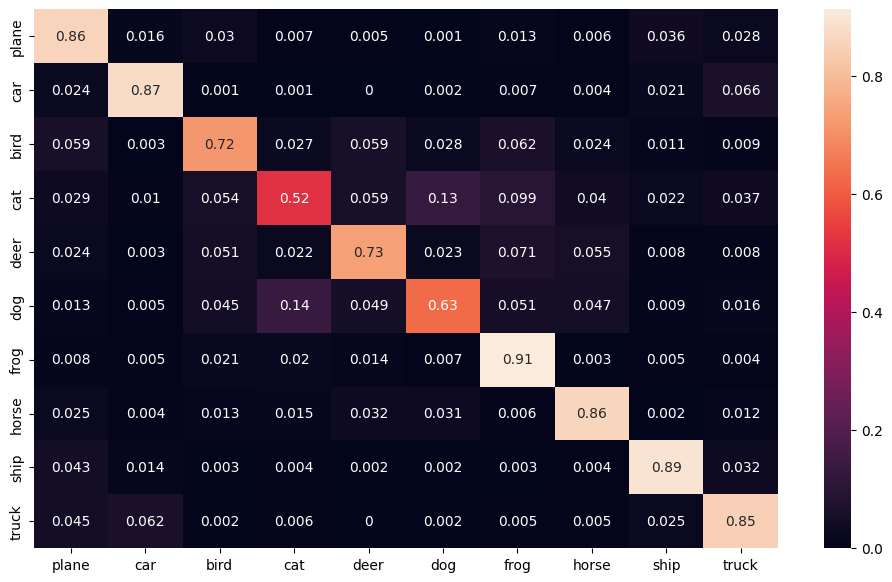

In [7]:
device = 'cuda'

# Get trained model from wandb
model_rcnn = CNN(layers = [3,4,2], num_classes = 10, residual = True).to(device)

run = wandb.init()

artifact = run.use_artifact('dla-labs/Lab1-Submission/ResidualCNN_20:v0', type='model')
artifact_dir = artifact.download()

run.finish()

transform = transforms.Compose(
    [transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616))])
# See if the model is the correct one.
# Load CIFAR10 test.
cifar10_test_acc = CIFAR10(root='./data', train=False, download=True, transform=transform)
# Dataloader
dl_test_cifar_acc = torch.utils.data.DataLoader(cifar10_test_acc, 256, shuffle=True)

model_rcnn.load_state_dict(torch.load(artifact_dir+'/best_model_rcnn.pth'))

test_accuracy = evaluate(model_rcnn, dl_test_cifar_acc, 5000, classes = classes, device = device, test = True)

### Layer 3

Files already downloaded and verified


Forward hook running...
Backward hook running...
Heatmap:


/data01/dl24nicara/DLA/.venv/lib/python3.10/site-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


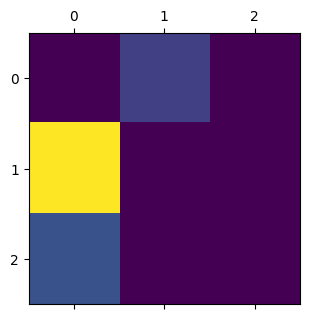

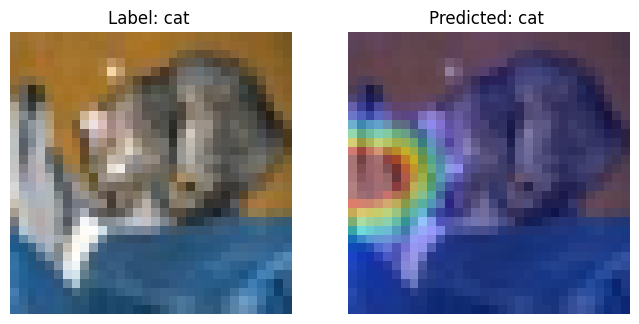

Forward hook running...
Backward hook running...
Heatmap:


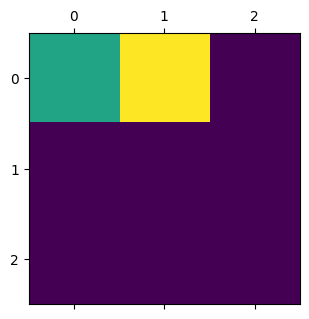

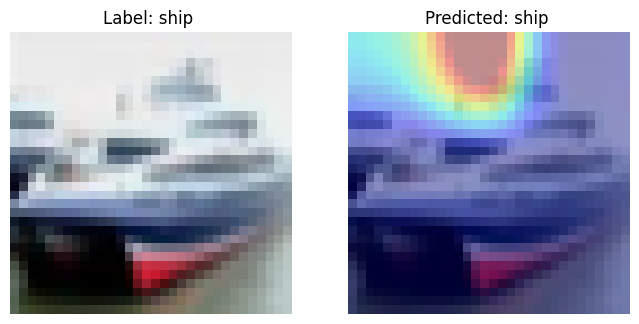

Forward hook running...
Backward hook running...
Heatmap:


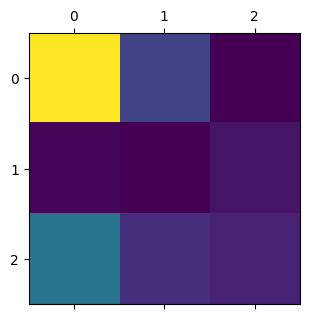

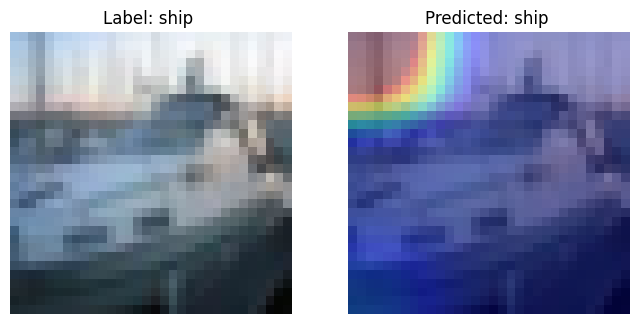

Forward hook running...
Backward hook running...
Heatmap:


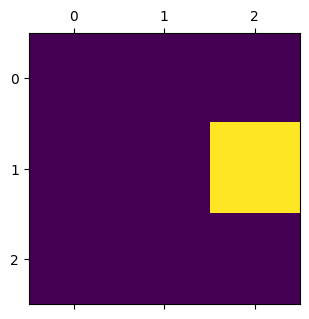

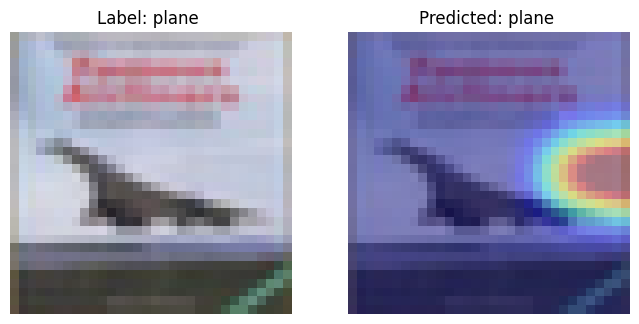

Forward hook running...
Backward hook running...
Heatmap:


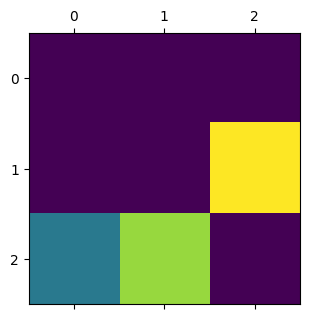

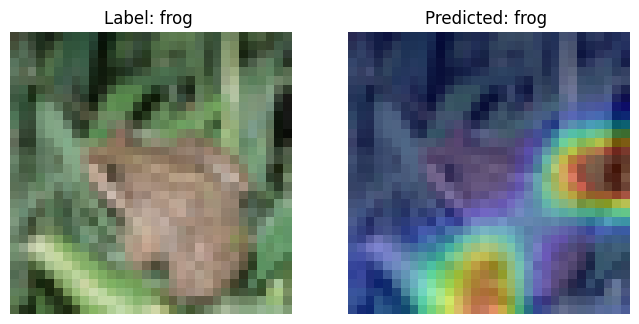

Forward hook running...
Backward hook running...
Heatmap:


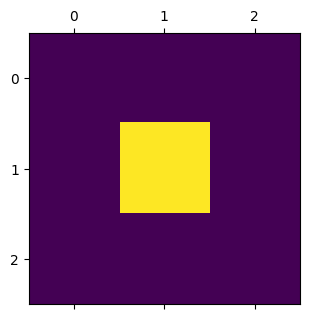

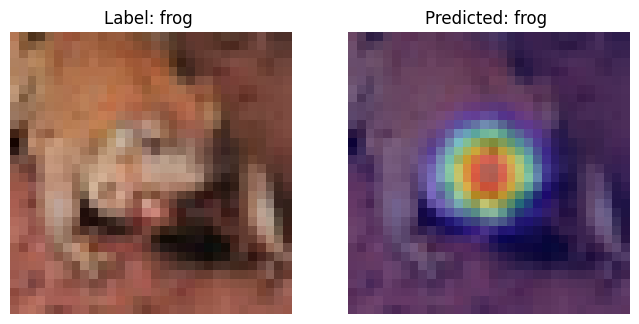

Forward hook running...
Backward hook running...
Heatmap:


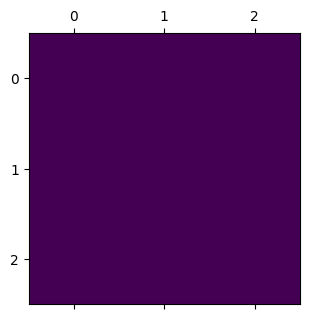

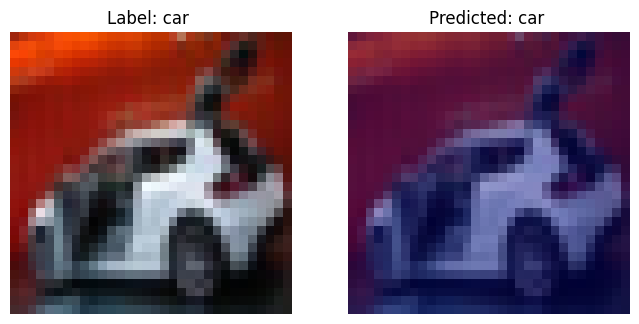

Forward hook running...
Backward hook running...
Heatmap:


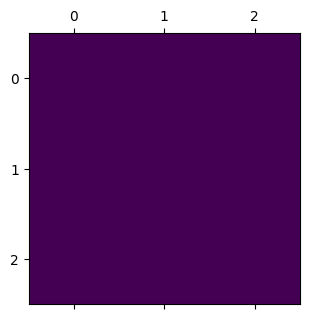

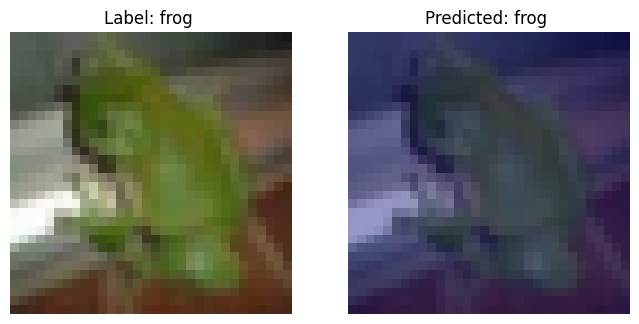

Forward hook running...
Backward hook running...
Heatmap:


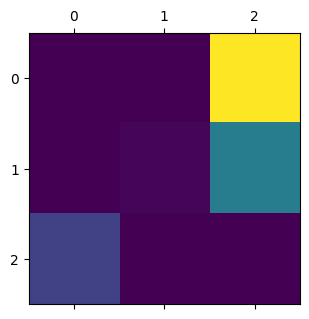

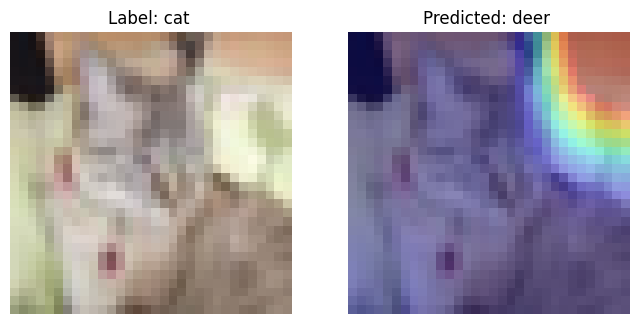

Forward hook running...
Backward hook running...
Heatmap:


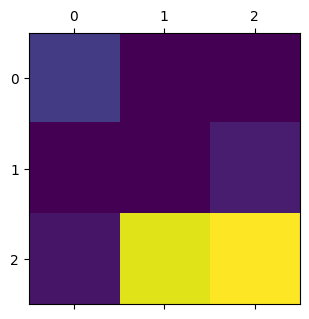

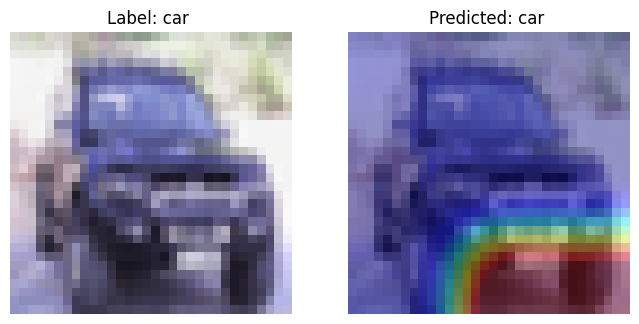

In [8]:
#Layer 3 prediction
# Register a backward hook on the module 
backward_hook_rCNN_3 = model_rcnn.layer3[-1].register_full_backward_hook(backward_hook, prepend=False)
# Register a forward hook on the module
forward_hook_rCNN_3 = model_rcnn.layer3[-1].register_forward_hook(forward_hook, prepend=False)

# Choosing a seed to get always the same images
torch.manual_seed(22)

# DataLoader with a single image per batch
ds_test = CIFAR10(root='./data', train=False, download=True, transform=transforms.ToTensor()) # Without normalization
dl_test = torch.utils.data.DataLoader(ds_test, batch_size=1, shuffle=False)
iter_dl_test = iter(dl_test)

for _ in range(10):
    gradCAM(model_rcnn, iter_dl_test)

### Layer 2

Forward hook running...
Backward hook running...
Heatmap:


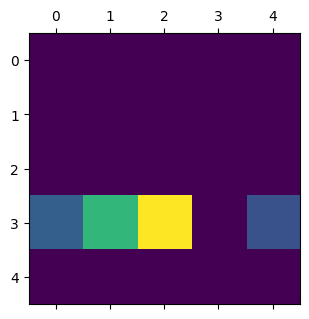

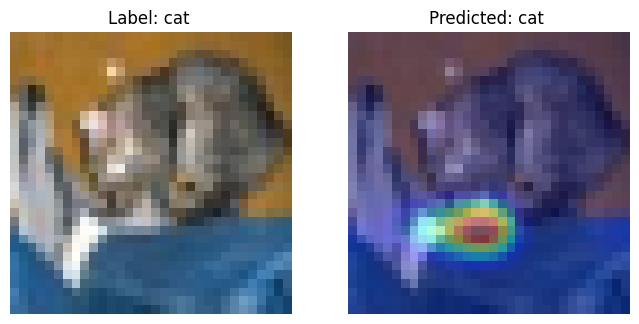

Forward hook running...
Backward hook running...
Heatmap:


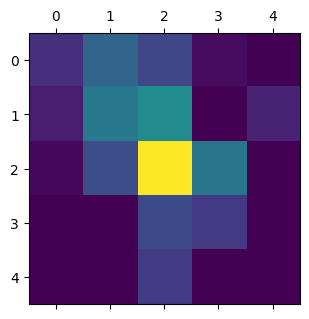

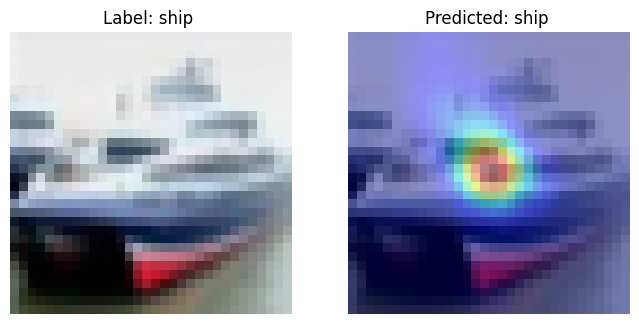

Forward hook running...
Backward hook running...
Heatmap:


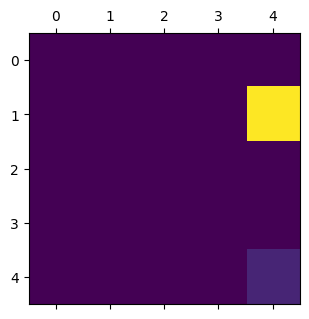

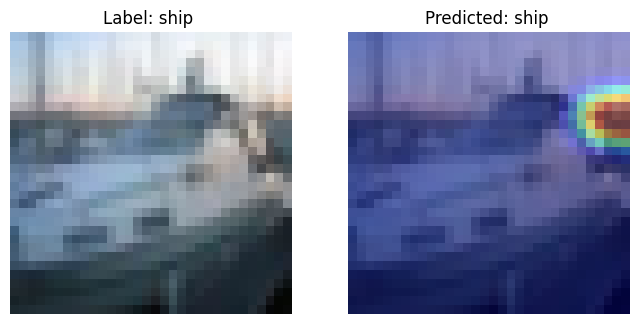

Forward hook running...
Backward hook running...
Heatmap:


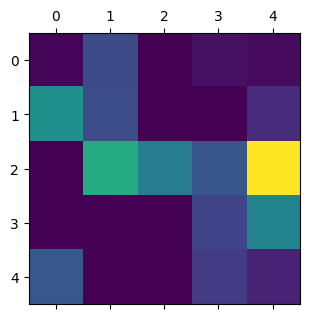

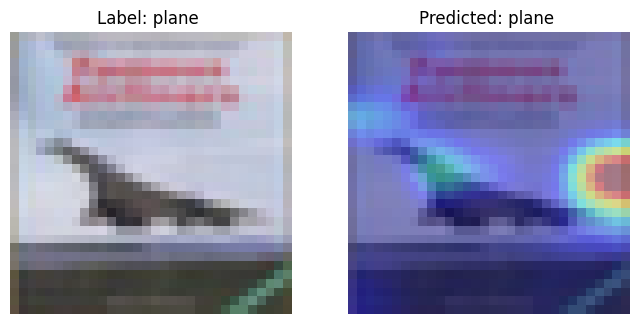

Forward hook running...
Backward hook running...
Heatmap:


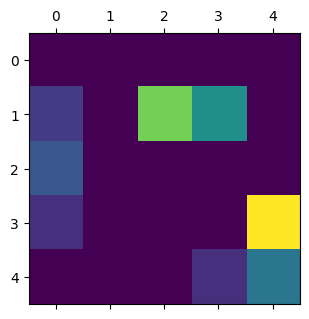

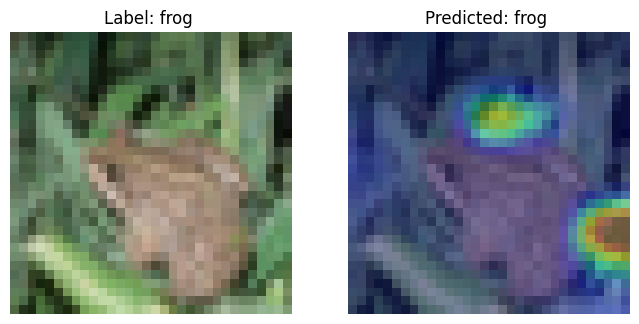

Forward hook running...
Backward hook running...
Heatmap:


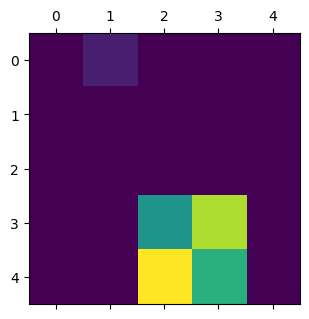

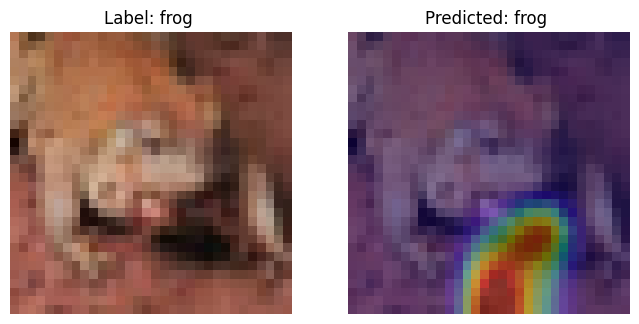

Forward hook running...
Backward hook running...
Heatmap:


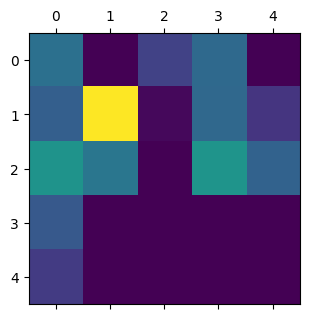

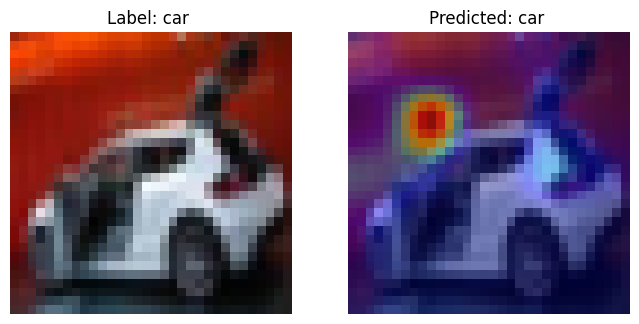

Forward hook running...
Backward hook running...
Heatmap:


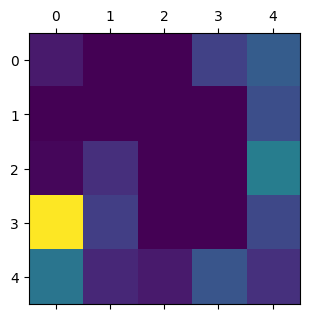

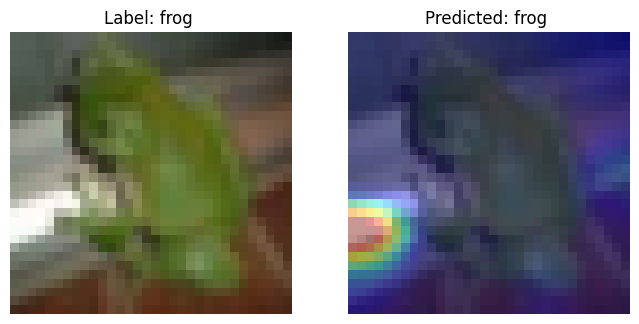

Forward hook running...
Backward hook running...
Heatmap:


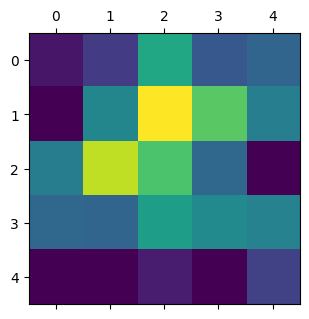

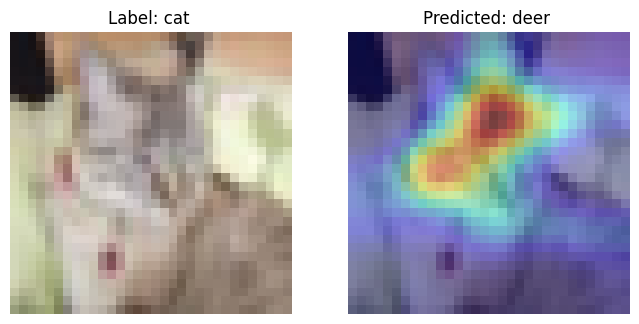

Forward hook running...
Backward hook running...
Heatmap:


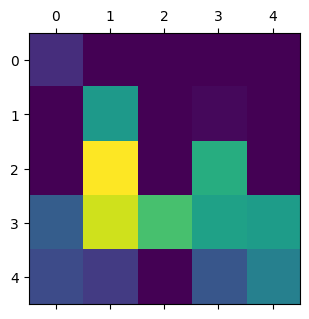

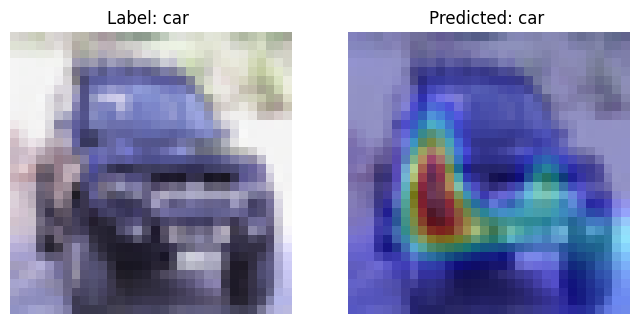

In [9]:
backward_hook_rCNN_3.remove()
forward_hook_rCNN_3.remove()

# Layer 2 Prediction
# Register a backward hook on the module 
backward_hook_rCNN_2 = model_rcnn.layer2[-1].register_full_backward_hook(backward_hook, prepend=False)
# Register a forward hook on the module
forward_hook_rCNN_2 = model_rcnn.layer2[-1].register_forward_hook(forward_hook, prepend=False)

# Choosing a seed to get always the same images
torch.manual_seed(22)
iter_dl_test = iter(dl_test)

for _ in range(10):
    gradCAM(model_rcnn, iter_dl_test)

### Layer 1

Forward hook running...
Backward hook running...
Heatmap:


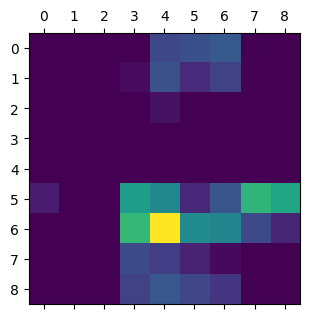

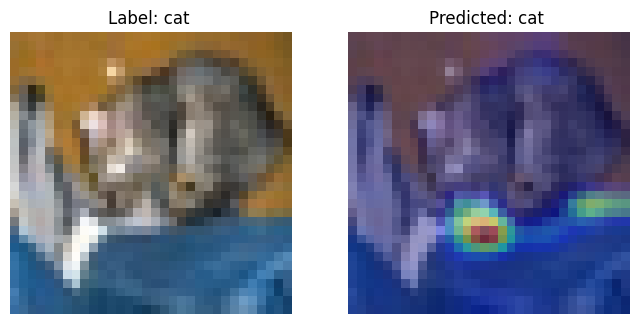

Forward hook running...
Backward hook running...
Heatmap:


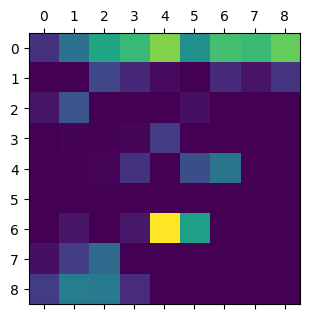

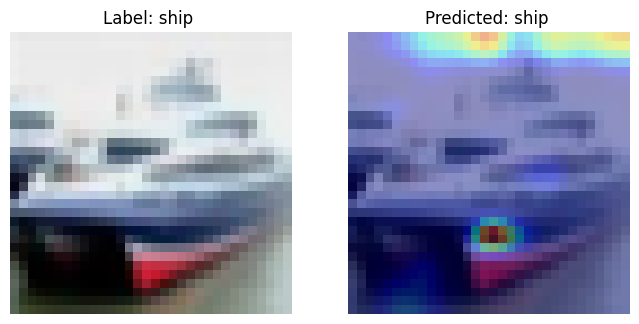

Forward hook running...
Backward hook running...
Heatmap:


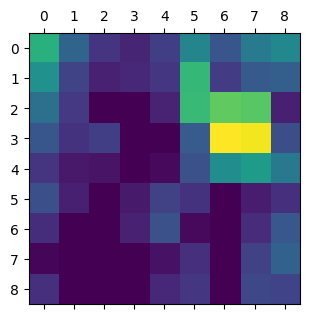

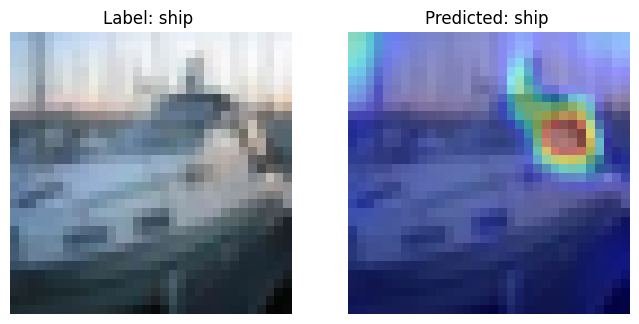

Forward hook running...
Backward hook running...
Heatmap:


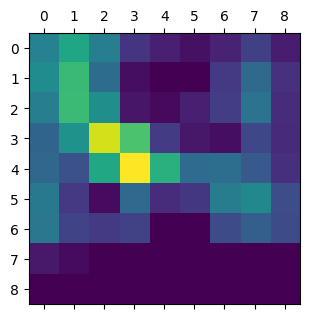

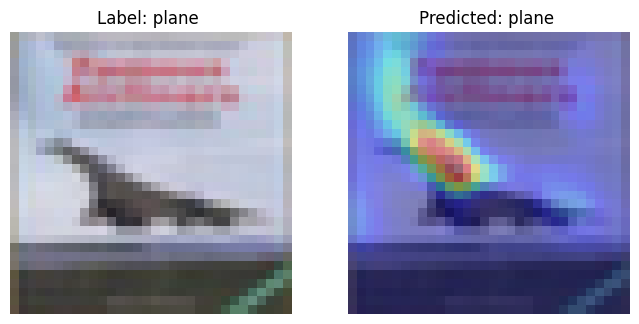

Forward hook running...
Backward hook running...
Heatmap:


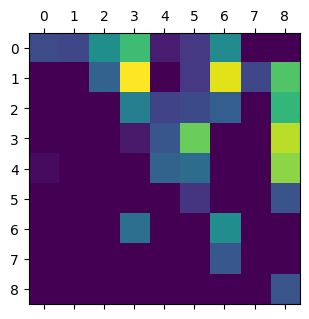

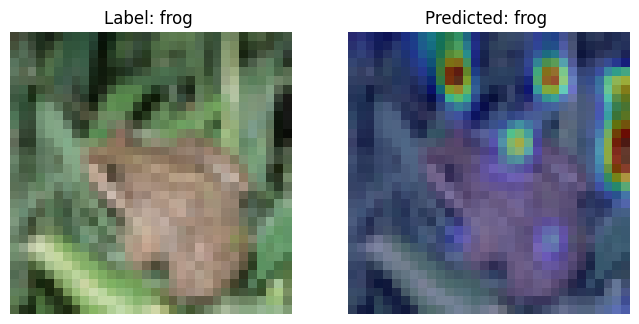

Forward hook running...
Backward hook running...
Heatmap:


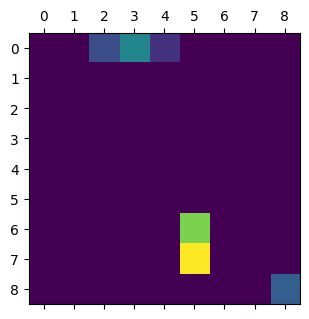

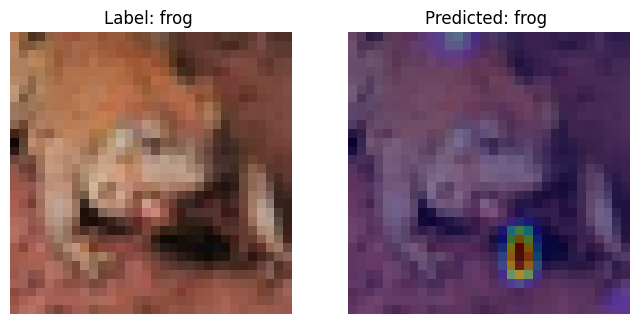

Forward hook running...
Backward hook running...
Heatmap:


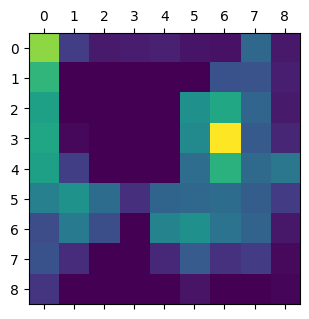

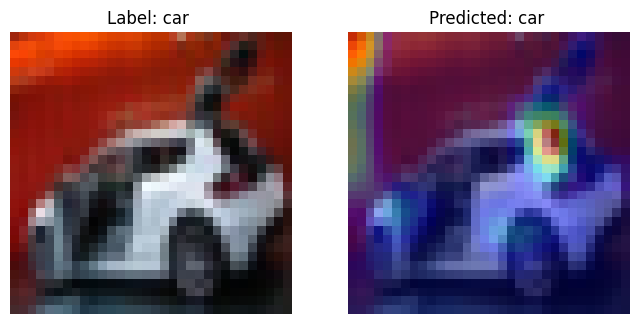

Forward hook running...
Backward hook running...
Heatmap:


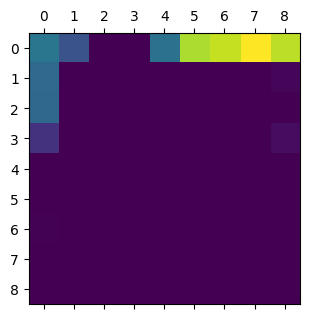

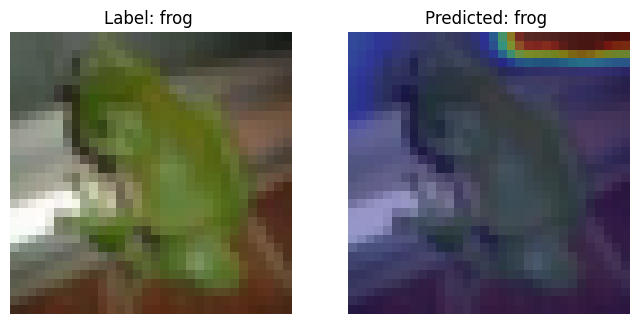

Forward hook running...
Backward hook running...
Heatmap:


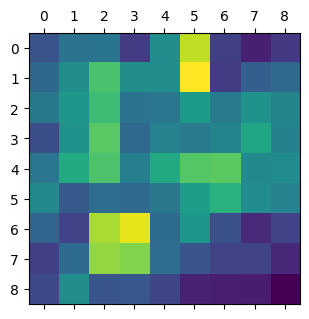

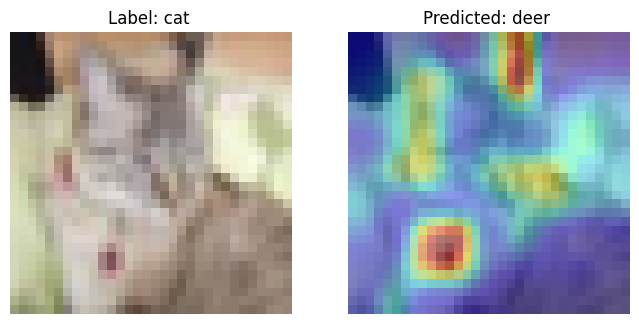

Forward hook running...
Backward hook running...
Heatmap:


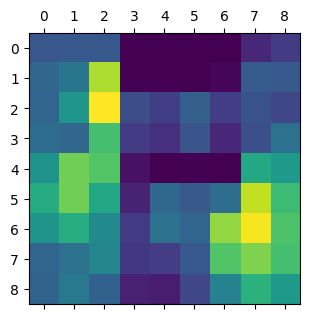

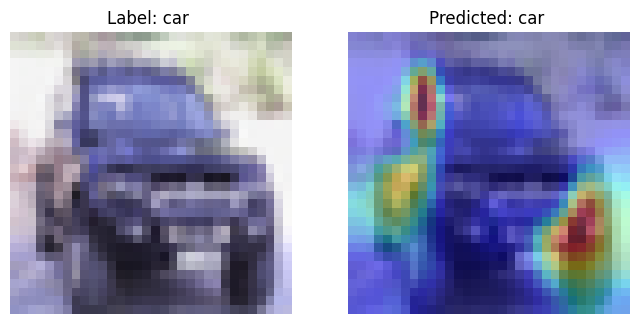

In [10]:
backward_hook_rCNN_2.remove()
forward_hook_rCNN_2.remove()

# Layer 1 Prediction
# Register a backward hook on the module 
backward_hook_CNN_1 = model_rcnn.layer1[-1].register_full_backward_hook(backward_hook, prepend=False)
# Register a forward hook on the module
forward_hook_CNN_1 = model_rcnn.layer1[-1].register_forward_hook(forward_hook, prepend=False)

# Choosing a seed to get always the same images
torch.manual_seed(22)
iter_dl_test = iter(dl_test)

for _ in range(10):
    gradCAM(model_rcnn, iter_dl_test)

### Final comments on Grad-CAM examples
Since the images in CIFAR-10 have a low resolution (32x32), the heatmaps generated from the feature maps of the third layer are very small (3x3) and, therefore, often not informative. The situation improves when using the feature maps from earlier layers, as the image resolution has been reduced less (according to the architecture of the CNNs used in this notebook).

Below there are some examples, with the heatmaps shown in the order of the layers:

![Alt text](ex2-1.png)

![Alt text](ex2-2.png)

![Alt text](ex2-3.png)

In this first example, we can observe how the heatmap gradually loses focus on the airplane's wing, even though the prediction remains accurate.

![Alt text](ex1-1.png)

![Alt text](ex1-2.png)

![Alt text](ex1-3.png)

In the second example, we observe an incorrect prediction. In the third layer, with the reduced heatmap, the focus shifts to the background, while in the previous layers it seems centered on the cat's ears. If we would try to justify the prediction error, we could speculate that, due to the low resolution of the image, the cat's pointed ears were mistaken for horns.

![Alt text](ex3-1.png)

![Alt text](ex3-2.png)

![Alt text](ex3-3.png)

In this final example, we can observe that as we take feature maps from deeper levels, the prediction relies on increasingly precise details. For instance, at layer 3, the heatmap appears to be focused on the frog's legs, whereas in the earlier layers, it was concentrated on more general features.